# Machine Learning for Single-Cell Biology Workshop
## Arian Amani
Data Scientist | Wellcome Sanger Institute | Sapienza University of Rome
* [LinkedIn](https://www.linkedin.com/in/arianamani/)
* [GitHub](https://github.com/ArianAmani)
* [Website](https://arianamani.github.io/)


I'm using slides from the Machine Learning course at Sharif University of Technology (some of them made by me) as reference for the theoretical parts of the workshop.

Course Slides and Material for more information: [Github](https://github.com/SharifiZarchi/Introduction_to_Machine_Learning/tree/main/Previous_Semesters/1401_01)

In [ ]:
!pip install scanpy

In [ ]:
import scanpy as sc
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_classification

## 6. Introduction to Deep Learning
* Neural Networks
* Deep Learning vs Traditional ML
* How DL is good in handling large-scale high-dimensional data

Once again, let's go to our slides to have a theoretical review of what we are going to see. (Using slides from CS 404/504, Spring 2023, University of Idaho here)

In [ ]:
# Create a complex non-linear multi-class classification dataset
X, y = make_classification(n_samples=2000, n_features=50, n_classes=5,
                           n_informative=30, n_redundant=10, n_clusters_per_class=3,
                           class_sep=1.5, random_state=42)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


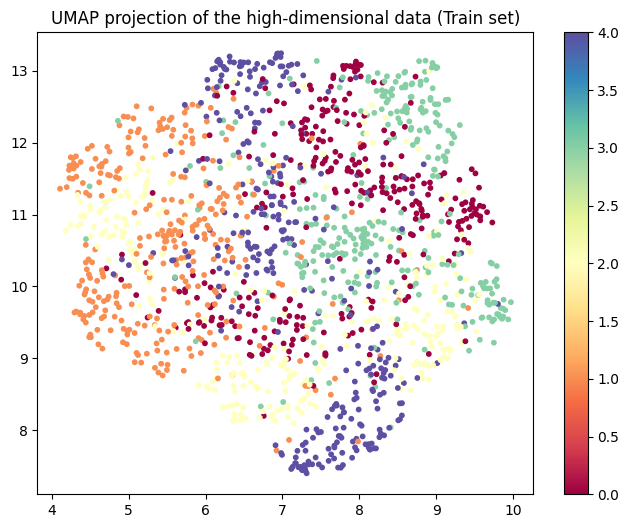

In [ ]:
import umap
import matplotlib.pyplot as plt

# Perform UMAP projection to 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_train)

# Plot UMAP visualization of the training data
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap='Spectral', s=10)
plt.title('UMAP projection of the high-dimensional data (Train set)')
plt.colorbar()
plt.show()


In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class DeepNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)  # Adding dropout for regularization

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation after final layer, because we'll apply softmax later
        return x

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
output_dim = len(set(y_train))  # 5 classes

# Model, loss function, and optimizer
model = DeepNN(input_dim, hidden_dim, output_dim).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

X_train_tensor = X_train_tensor.to('cuda')
y_train_tensor = y_train_tensor.to('cuda')
# Training loop
epochs = 15000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

X_test_tensor = X_test_tensor.to('cuda')
y_test_tensor = y_test_tensor.to('cuda')
# Testing
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    nn_accuracy = (predicted == y_test_tensor).float().mean().item() * 100
    print(f'Neural Network Accuracy: {nn_accuracy:.2f}%')

Epoch [1000/15000], Loss: 0.0110
Epoch [2000/15000], Loss: 0.0073
Epoch [3000/15000], Loss: 0.0027
Epoch [4000/15000], Loss: 0.0023
Epoch [5000/15000], Loss: 0.0014
Epoch [6000/15000], Loss: 0.0006
Epoch [7000/15000], Loss: 0.0004
Epoch [8000/15000], Loss: 0.0020
Epoch [9000/15000], Loss: 0.0006
Epoch [10000/15000], Loss: 0.0003
Epoch [11000/15000], Loss: 0.0002
Epoch [12000/15000], Loss: 0.0001
Epoch [13000/15000], Loss: 0.0001
Epoch [14000/15000], Loss: 0.0002
Epoch [15000/15000], Loss: 0.0023
Neural Network Accuracy: 85.50%


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and accuracy for Random Forest
rf_preds = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds) * 100
print(f'Random Forest Accuracy: {rf_accuracy:.2f}%')

Random Forest Accuracy: 69.50%


In [ ]:
print(f'Performance Comparison:')
print(f'Neural Network Accuracy: {nn_accuracy:.2f}%')
print(f'Random Forest Accuracy: {rf_accuracy:.2f}%')

Performance Comparison:
Neural Network Accuracy: 85.50%
Random Forest Accuracy: 69.50%


## How DL is good in handling large-scale high-dimensional data

In [ ]:
adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata
del adata.obsm['X_pca']
del adata.obsm['X_umap']

  0%|          | 0.00/36.6M [00:00<?, ?B/s]

In [ ]:
adata.obs['cell_type'].value_counts()

,count
cell_type,
CD4 T cells,11238
CD14+ Monocytes,5697
B cells,2651
NK cells,1716
CD8 T cells,1621
FCGR3A+ Monocytes,1089
Dendritic cells,529
Megakaryocytes,132


In [ ]:
adata = adata[adata.obs['cell_type'] != 'Megakaryocytes'].copy()

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.shape

(24540, 15698)

In [ ]:
# Storing the counts for later use
adata.layers["counts"] = adata.X.copy()

# Normalizing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
# Finding highly variable genes using count data
sc.pp.highly_variable_genes(
    adata, n_top_genes=5000, subset=True,
)

In [ ]:
X = adata.X.toarray()
y = adata.obs['cell_type'].values
y = y.factorize()[0]  # Convert labels to integers
X.shape, y.shape

((24540, 5000), (24540,))

In [ ]:
adata.obs['cell_type'].unique()

['CD14+ Monocytes', 'CD4 T cells', 'Dendritic cells', 'NK cells', 'CD8 T cells', 'B cells', 'FCGR3A+ Monocytes']
Categories (7, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'CD8 T cells',
                         'FCGR3A+ Monocytes', 'Dendritic cells']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train-test split (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# number of each class in y_test
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 863, 1: 1691, 2: 64, 3: 265, 4: 244, 5: 396, 6: 158}

In [ ]:
adata.obs['cell_type'].value_counts()

,count
cell_type,
CD4 T cells,11238
CD14+ Monocytes,5696
B cells,2651
NK cells,1716
CD8 T cells,1621
FCGR3A+ Monocytes,1089
Dendritic cells,529


In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_preds))

Random Forest Accuracy: 0.967400162999185
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       863
           1       0.98      0.99      0.99      1691
           2       1.00      0.70      0.83        64
           3       0.92      0.96      0.94       265
           4       0.90      0.83      0.86       244
           5       0.99      0.99      0.99       396
           6       1.00      0.84      0.91       158

    accuracy                           0.97      3681
   macro avg       0.96      0.90      0.93      3681
weighted avg       0.97      0.97      0.97      3681



In [ ]:
X_train.min(), X_train.max()

(0.0, 6.6477623)

In [ ]:
# Preprocess the features for a neural network (They are in log-normalized format: value range: [0, 6.6]) | Data shape is (n, 1000) --> 1000 features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
X_train.min(), X_train.max()

(0.0, 1.0)

In [ ]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Hyperparameters (adjustable)
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
hidden_layer1_size = 64               # First hidden layer neurons
hidden_layer2_size = 64                # Second hidden layer neurons
dropout_rate = 0.5                     # Dropout rate to prevent overfitting
learning_rate = 0.0001                  # Learning rate
batch_size = 256                        # Batch size
epochs = 50                            # Number of epochs
weight_decay = 1e-3                    # L2 regularization


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, num_classes, dropout_rate):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer1_size)
        # self.layernorm1 = nn.LayerNorm(hidden_layer1_size)  # LayerNorm for the first layer
        self.layernorm1 = nn.BatchNorm1d(hidden_layer1_size)  # BatchNorm for the first layer

        self.relu1 = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer

        self.fc2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)
        # self.layernorm2 = nn.LayerNorm(hidden_layer2_size)  # LayerNorm for the second layer
        self.layernorm2 = nn.BatchNorm1d(hidden_layer2_size)  # BatchNorm for the second layer
        self.relu2 = nn.LeakyReLU()

        self.fc3 = nn.Linear(hidden_layer2_size, num_classes)

    def forward(self, x):
        # First layer
        out = self.fc1(x)
        out = self.layernorm1(out)  # Apply LayerNorm
        out = self.relu1(out)
        out = self.dropout(out)

        # Second layer
        out = self.fc2(out)
        out = self.layernorm2(out)  # Apply LayerNorm
        out = self.relu2(out)
        out = self.dropout(out)

        # Output layer
        out = self.fc3(out)
        return out


In [ ]:
# Instantiate the model
model = NeuralNet(input_size, hidden_layer1_size, hidden_layer2_size, num_classes, dropout_rate).to('cuda')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Early stopping parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        X_val_tensor = X_val_tensor.to('cuda')
        y_val_tensor = y_val_tensor.to('cuda')
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        X_val_tensor = X_val_tensor.to('cpu')
        y_val_tensor = y_val_tensor.to('cpu')

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Final evaluation on test set
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to('cuda')
    y_test_tensor = y_test_tensor.to('cuda')
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    X_test_tensor = X_test_tensor.to('cpu')
    y_test_tensor = y_test_tensor.to('cpu')
    predicted = predicted.cpu()

    test_accuracy = accuracy_score(y_test_tensor, predicted)
    print("Test Accuracy:", test_accuracy)
    print("Classification Report:")
    print(classification_report(y_test_tensor, predicted))

Epoch [1/50], Train Loss: 1.5524, Val Loss: 1.2674
Epoch [2/50], Train Loss: 1.1502, Val Loss: 0.9234
Epoch [3/50], Train Loss: 0.9193, Val Loss: 0.7366
Epoch [4/50], Train Loss: 0.7667, Val Loss: 0.5836
Epoch [5/50], Train Loss: 0.6560, Val Loss: 0.4922
Epoch [6/50], Train Loss: 0.5727, Val Loss: 0.4223
Epoch [7/50], Train Loss: 0.5004, Val Loss: 0.3688
Epoch [8/50], Train Loss: 0.4529, Val Loss: 0.3154
Epoch [9/50], Train Loss: 0.4097, Val Loss: 0.2825
Epoch [10/50], Train Loss: 0.3705, Val Loss: 0.2492
Epoch [11/50], Train Loss: 0.3351, Val Loss: 0.2253
Epoch [12/50], Train Loss: 0.3035, Val Loss: 0.1962
Epoch [13/50], Train Loss: 0.2827, Val Loss: 0.1795
Epoch [14/50], Train Loss: 0.2567, Val Loss: 0.1642
Epoch [15/50], Train Loss: 0.2389, Val Loss: 0.1528
Epoch [16/50], Train Loss: 0.2200, Val Loss: 0.1389
Epoch [17/50], Train Loss: 0.2056, Val Loss: 0.1296
Epoch [18/50], Train Loss: 0.1890, Val Loss: 0.1212
Epoch [19/50], Train Loss: 0.1739, Val Loss: 0.1152
Epoch [20/50], Train 